In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
from scipy.stats import norm

In [7]:
# We obtain the significant parameters
def get_stock_data(ticker, start_date):
    """
    This function gets the stock data for a given ticker, start date and end date.
    It uses the yfinance library to download the stock data, calculates the daily logarithmic returns,
    mean rate of return (u), volatility (var) and initial price.
    If the yfinance library fails to retrieve the stock data, it tries to use pandas_datareader library.
    """
    today = dt.date.today()
    end_date = today.strftime("%Y-%m-%d")
    try:
        # Get the stock data
        stock_data = yf.download(ticker, start=start_date, end=end_date)
    except:
        try:
            stock_data = pdr.get_data_yahoo(ticker, start_date, end_date)
        except:
            return "No data found, please try again later"

    returns = np.log(stock_data['Adj Close']/stock_data['Adj Close'].shift(1))

    returns = returns.dropna()

    u = returns.mean()

    var = returns.std()

    initial_price = stock_data['Adj Close'].iloc[-1]

    return u, var, initial_price

In [43]:
# MonteCarlo simulation function for Geometric Brownian Motion or Jump Diffusion
def monte_carlo_simulation(num_simulations, time_steps, mu, sigma, initial_price, diffusion_type='GBM', mu_j=0, sigma_j=0, lambda_=0):
    '''
    This function performs a Monte Carlo simulation of stock prices. It takes in the following parameters:

    num_simulations: the number of simulations to run
    time_steps: the number of time steps to simulate over
    mu: the mean of the log returns
    sigma: the standard deviation of the log returns
    initial_price: the initial stock price
    diffusion_type: the type of diffusion to use, either 'GBM' (Geometric Brownian Motion) or 'Jump' (Jump Diffusion). Default is 'GBM'.
    mu_j: the mean of the jump component. Default is 0.
    sigma_j: the standard deviation of the jump component. Default is 0.
    lambda_: the frequency of jumps. Default is 0.

    The function creates an array to store the simulated prices and sets the initial price for all simulations.
    It then sets the time step and chooses the type of diffusion. If the diffusion type is 'GBM',
    it uses the GBM equation to calculate the next price for each simulation. If the diffusion type is 'Jump',
    it uses the Jump Diffusion equation to calculate the next price for each simulation. The function returns an array of simulated prices.
    '''
    # Create an array to store the simulated prices
    sim_prices = np.zeros((num_simulations, time_steps))
    # Set the initial price for all simulations
    sim_prices[:, 0] = initial_price
    # Set the time step
    dt = 1 / time_steps
    # Choose the type of diffusion
    if diffusion_type == 'GBM':
        for i in range(1, time_steps):
            # Generate random numbers for each simulation
            rand = np.random.normal(0, 1, num_simulations)
            # Use GBM to calculate the next price for each simulation
            sim_prices[:, i] = sim_prices[:, i-1] * np.exp((mu - sigma**2 / 2) * dt + sigma * np.sqrt(dt) * rand)
    elif diffusion_type == 'Jump':
        for i in range(1, time_steps):
            # Generate random numbers for each simulation
            rand = np.random.normal(0, 1, num_simulations)
            # Generate random numbers for the jump component
            jump = np.random.normal(mu_j, sigma_j, num_simulations)
            # Use Jump Diffusion to calculate the next price for each simulation
            sim_prices[:, i] = sim_prices[:, i-1] * np.exp((mu - sigma**2 / 2 - lambda_ * (np.exp(mu_j + sigma_j ** 2 / 2) - 1)) * dt + sigma * np.sqrt(dt) * rand + jump)
    else:
        raise ValueError('Invalid diffusion type. Choose either GBM or Jump.')
    return sim_prices

In [4]:
# Create a plotly function to generate a chart
def plotly_chart():

    conf = [1,5,10]
    levels = []
    print(f'For {time_steps} time steps in {num_simulations} simulations for {ticker}')
    for i in conf:
        value_at_risk = np.percentile(sim_prices[:,-1], i)
        levels.append(value_at_risk)
        print(f'VAR at {100-i}% conf. level =  {(value_at_risk):.3f} $')


    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    # Create a figure
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'scatter'}, {'type':'histogram'}]], subplot_titles=[f"Price at start {(initial_price):.2f} [$]", "Distribution"], column_widths=[2,1])

    # Add lines for each simulation
    for i in range(num_simulations):
        fig.add_trace(go.Scatter(x=np.arange(time_steps), y=sim_prices[i,:], mode='lines'), row=1, col=1)# name='Simulation {}'.format(i+1)

    # Add a line for the average price
    fig.add_trace(go.Scatter(x=np.arange(time_steps), y=np.mean(sim_prices, axis=0), mode='lines'), row=1, col=1) # , name='Average Price'

    # Add a histogram of the simulated prices and vetical lines
    fig.add_trace(go.Histogram(x=sim_prices[:,-1], name='Simulated Prices'), row=1, col=2)
    fig.add_vline(x=levels[0], name='VAR 99%',  line_width=1, line_dash="dash", line_color="green", row=1, col=2)
    fig.add_vline(x=levels[1], name='VAR 95%',  line_width=1, line_dash="dash", line_color="blue", row=1, col=2)
    fig.add_vline(x=levels[2], name='VAR 90%',  line_width=1, line_dash="dash", line_color="black", row=1, col=2)


    # Set the layout
    fig.update_layout(title=f'Monte Carlo Simulation of Stock Prices for {ticker} with metrics extracted from {start_date} until today',
                      xaxis_title='Steps',
                      yaxis_title='Price',
                      showlegend=False)

    # Show the figure
    fig.show()

In [15]:
start_date = '2015-01-01'
ticker = 'CIB'
# Montecarlo Parameters
num_simulations = 1000
time_steps = 100
diffusion_type ='GBM' # or 'Jump' and if jump, add mu_j, sigma_j, lambda_ to the function

In [16]:
u, var, initial_price = get_stock_data(ticker, start_date)
print(f'\nTicker:{ticker} Mean: {u} STD: {var} Initial Price: {initial_price}')

[*********************100%%**********************]  1 of 1 completed


Ticker:CIB Mean: 1.8050327780570622e-05 STD: 0.023060104008790137 Initial Price: 31.06999969482422


In [49]:
sim_prices = monte_carlo_simulation(num_simulations, time_steps, u, var, initial_price, diffusion_type)
print(len(sim_prices))
plotly_chart()

1000
For 100 time steps in 1000 simulations for CIB
VAR at 99% conf. level =  29.350 $
VAR at 95% conf. level =  29.870 $
VAR at 90% conf. level =  30.158 $


In [50]:
data_prices = pd.DataFrame(sim_prices).T
data_prices.index = pd.bdate_range(start=dt.datetime.now(), periods=time_steps)
data_prices.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2024-08-06,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,...,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000
2024-08-07,31.099230,30.993022,31.041707,31.040042,31.073717,31.233530,31.074192,31.015964,30.970672,31.181079,...,31.045338,30.971607,30.933131,31.189793,31.053232,31.122261,30.960506,31.143856,31.133420,31.047308
2024-08-08,31.201838,30.961071,31.157435,30.899327,31.083083,31.219008,31.139160,30.932647,30.943920,31.200628,...,31.007532,30.993093,30.882478,31.183518,31.132921,31.124588,31.040747,31.204266,31.098689,31.119198
2024-08-09,31.148101,30.874423,31.079204,30.917717,30.962416,31.304508,31.132524,30.840573,30.973397,31.242551,...,30.952214,31.060026,30.811937,31.166961,31.189719,31.160243,30.971738,31.240559,31.113433,31.110061
2024-08-12,31.219525,30.833781,31.061963,30.941939,30.886618,31.419785,31.190865,30.928641,30.927587,31.266562,...,30.818328,31.019668,30.716932,31.271553,31.151883,31.203615,31.101622,31.207997,31.098953,31.229752


In [51]:
data_prices['Mean_Price'] = data_prices.mean(axis=1)
data_prices.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Mean_Price
2024-08-06,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,...,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000,31.070000
2024-08-07,31.099230,30.993022,31.041707,31.040042,31.073717,31.233530,31.074192,31.015964,30.970672,31.181079,...,30.971607,30.933131,31.189793,31.053232,31.122261,30.960506,31.143856,31.133420,31.047308,31.070392
2024-08-08,31.201838,30.961071,31.157435,30.899327,31.083083,31.219008,31.139160,30.932647,30.943920,31.200628,...,30.993093,30.882478,31.183518,31.132921,31.124588,31.040747,31.204266,31.098689,31.119198,31.070272
2024-08-09,31.148101,30.874423,31.079204,30.917717,30.962416,31.304508,31.132524,30.840573,30.973397,31.242551,...,31.060026,30.811937,31.166961,31.189719,31.160243,30.971738,31.240559,31.113433,31.110061,31.066678
2024-08-12,31.219525,30.833781,31.061963,30.941939,30.886618,31.419785,31.190865,30.928641,30.927587,31.266562,...,31.019668,30.716932,31.271553,31.151883,31.203615,31.101622,31.207997,31.098953,31.229752,31.066988


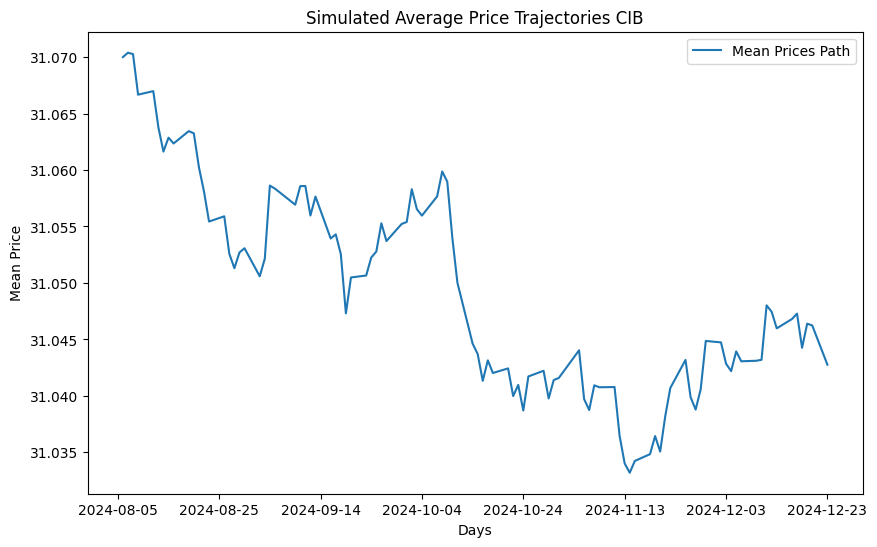

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(data_prices.index, data_prices['Mean_Price'], label='Mean Prices Path')
plt.title(f'Simulated Average Price Trajectories {ticker}')
plt.xlabel('Days')
plt.ylabel('Mean Price')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
plt.legend()
plt.show()